In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pandas as pd

import sys
sys.path.append('../')
from src import data

from netneurotools import metrics 

import mne

%matplotlib widget

!date -I

2024-03-01


In [2]:
def plot_data(data,title=None):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure()
    plt.plot(data);
    plt.title(title)
    plt.show()

def plot_one_roi(data,roi_id,labels,title=None,constants=[]):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure()
    plt.plot(data[:,roi_id])
    for c in constants:
        plt.plot([c]*400)
    plt.title(labels[roi_id])
    plt.show()

## Load data

### Load pytepfit data

In [3]:
data_pytepfit = np.load('../data/external/pytepfit/source_estimates/empirical.npz')
data_pytepfit['ts'].shape

(400, 200)

In [4]:
data_pytepfit['labels'][:10]

array(['7Networks_LH_Cont_Cing_1-lh', '7Networks_LH_Cont_Cing_2-lh',
       '7Networks_LH_Cont_PFCl_1-lh', '7Networks_LH_Cont_PFCl_2-lh',
       '7Networks_LH_Cont_PFCl_3-lh', '7Networks_LH_Cont_PFCl_4-lh',
       '7Networks_LH_Cont_PFCl_5-lh', '7Networks_LH_Cont_PFCl_6-lh',
       '7Networks_LH_Cont_Par_1-lh', '7Networks_LH_Cont_Par_2-lh'],
      dtype='<U40')

In [5]:
data_pytepfit['labels'].shape

(200,)

In [6]:
data_pytepfit['labels'][:10]

array(['7Networks_LH_Cont_Cing_1-lh', '7Networks_LH_Cont_Cing_2-lh',
       '7Networks_LH_Cont_PFCl_1-lh', '7Networks_LH_Cont_PFCl_2-lh',
       '7Networks_LH_Cont_PFCl_3-lh', '7Networks_LH_Cont_PFCl_4-lh',
       '7Networks_LH_Cont_PFCl_5-lh', '7Networks_LH_Cont_PFCl_6-lh',
       '7Networks_LH_Cont_Par_1-lh', '7Networks_LH_Cont_Par_2-lh'],
      dtype='<U40')

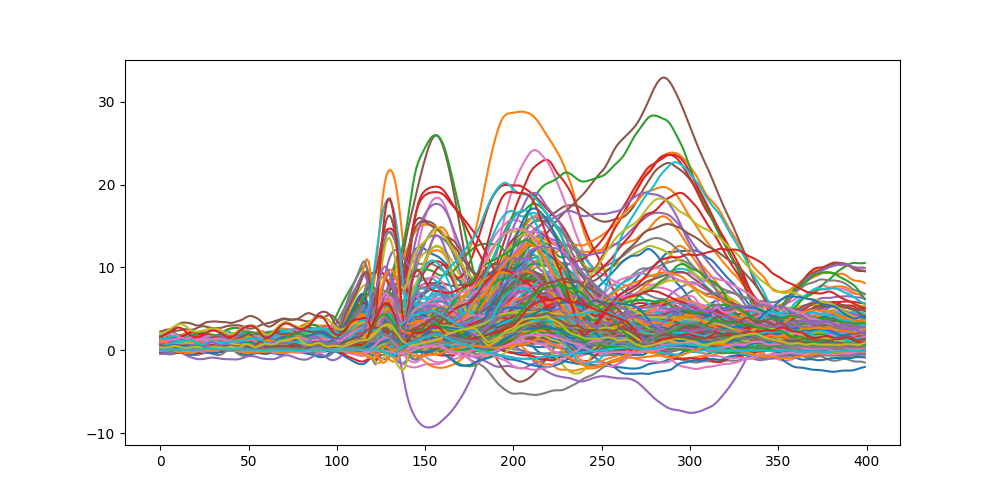

In [7]:
plot_data(data_pytepfit['ts'])

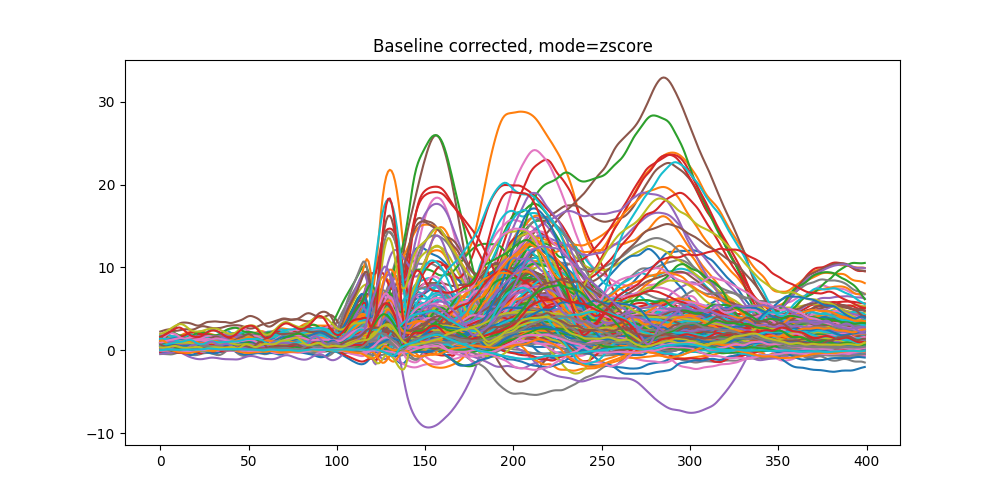

In [8]:
baseline_correction_mode = 'zscore'
# corrected = mne.baseline.rescale(data_pytepfit['ts'].T, np.array([i for i in range(400)]), (0,99), mode=baseline_correction_mode).T
corrected = data_pytepfit['ts']


plot_data(corrected,title=f'Baseline corrected, mode={baseline_correction_mode}')

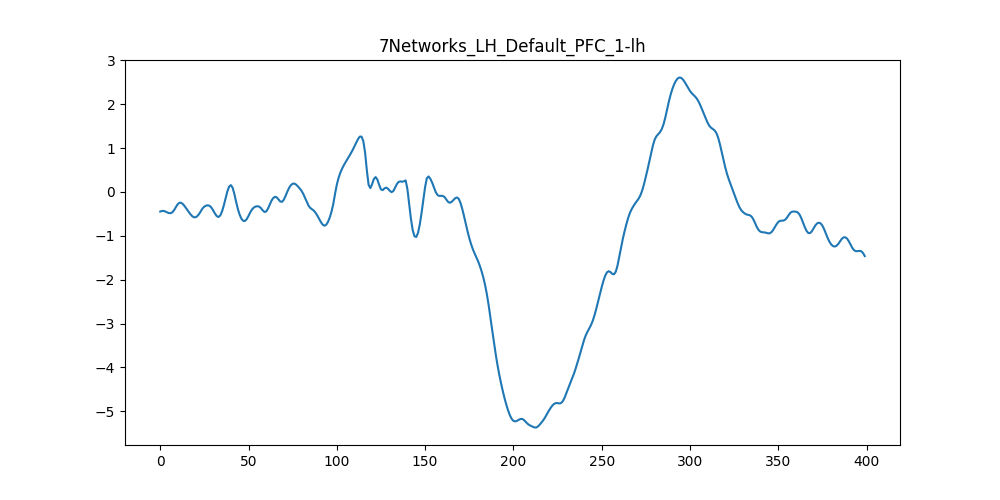

In [9]:
plot_one_roi(corrected,17,data_pytepfit['labels'])

In [10]:
def get_amplitude_first_peak(seqence, threshold):
    id_above_threshold = None
    for i,val in enumerate(seqence):
        if val > threshold or val < -threshold:
            id_above_threshold = i
            break

    if id_above_threshold is None:
        return None

    max_value_above_threshold = seqence[id_above_threshold]
    while id_above_threshold < len(seqence) and (seqence[id_above_threshold] > threshold or seqence[id_above_threshold] < -threshold): 
        if seqence[id_above_threshold] > abs(max_value_above_threshold):
            max_value_above_threshold = abs(seqence[id_above_threshold])
        id_above_threshold += 1
    
    return max_value_above_threshold

def get_amplitude_first_peak_id(seqence, threshold):
    id_above_threshold = None
    for i,val in enumerate(seqence):
        if val > threshold or val < -threshold:
            id_above_threshold = i
            break

    if id_above_threshold is None:
        return None

    max_value_above_threshold = seqence[id_above_threshold]
    max_value_above_threshold_id = id_above_threshold
    
    while id_above_threshold < len(seqence) and (seqence[id_above_threshold] > threshold or seqence[id_above_threshold] < -threshold): 
        if seqence[id_above_threshold] > abs(max_value_above_threshold):
            max_value_above_threshold = abs(seqence[id_above_threshold])
            max_value_above_threshold_id = id_above_threshold
        id_above_threshold += 1
    
    return max_value_above_threshold_id

def get_amplitude_highest_peak(seqence, threshold):
    val = seqence[np.argmax(np.abs(seqence))]

    if val > threshold or val < -threshold:
        return abs(val)
    return None

def get_amplitude_highest_peak_id(seqence, threshold):
    argmax = np.argmax(np.abs(seqence))
    val = seqence[argmax]

    if val > threshold or val < -threshold:
        return argmax
    return None

def estimate_auc(seqence, threshold):
    estimate = 0

    for v in seqence:
        if abs(v) > threshold:
            estimate += abs(v)

    if estimate > 0:
        return estimate

    return None
    

def get_threshold_range(corrected_data,stim_idx):
    # TODO předělat upper, protože takhle poslední dvě hodnoty nedávají smysl?
    maxima = np.max(corrected[stim_idx:,:],axis=0)
    maxima.sort()

    upper = int(maxima[-5])
    lower = int(np.max(corrected_data[:stim_idx,:]))
    step = int((upper - lower) / 7)

    return range(lower, upper, step)

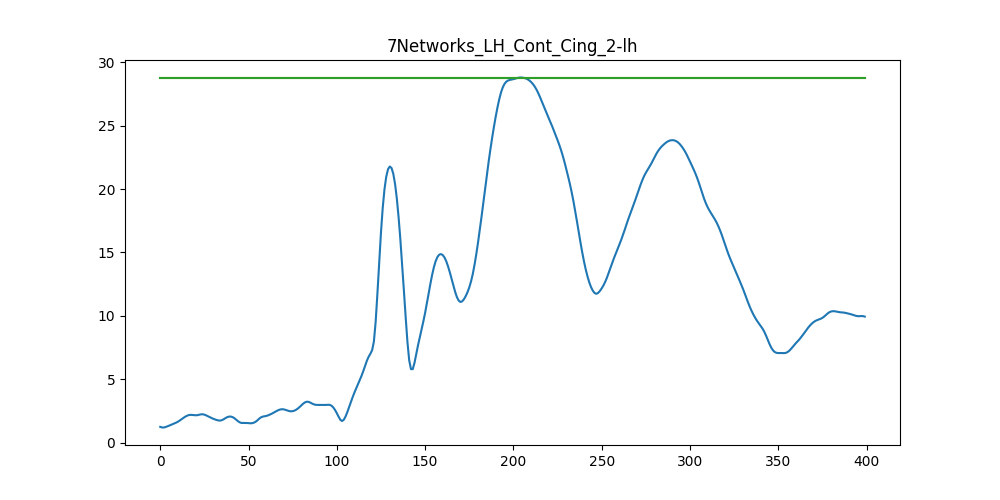

In [11]:
roi_idx = 1

amp = get_amplitude_first_peak(corrected[:,roi_idx],threshold=5)
amp_h = get_amplitude_highest_peak(corrected[:,roi_idx],threshold=5)

plot_one_roi(corrected,roi_idx,labels=data_pytepfit['labels'],constants=[amp,amp_h])

In [12]:
responses = {} 
stim_time = 100

df_responses = pd.DataFrame()

thr_range = get_threshold_range(corrected,stim_time)

from sklearn import metrics as sk_metrics
# sklearn.metrics.auc(x, y)

for threshold in thr_range:

    response_df = pd.DataFrame(index=range(200), columns=['01-response','amp_highest','amp_first'])

    maxima = np.max(corrected,axis=0)
    response_df['01-response'] = maxima > threshold
    response_df['amp_first'] = np.array([get_amplitude_first_peak(corrected[stim_time:,i],threshold) for i in range(200)],dtype=float)
    response_df['amp_first_id'] = np.array([get_amplitude_first_peak_id(corrected[stim_time:,i],threshold) for i in range(200)],dtype=float)
    response_df['amp_highest'] = np.array([get_amplitude_highest_peak(corrected[stim_time:,i],threshold) for i in range(200)],dtype=float)
    response_df['amp_highest_id'] = np.array([get_amplitude_highest_peak_id(corrected[stim_time:,i],threshold) for i in range(200)],dtype=float)
    response_df['variance'] = np.var(corrected[stim_time:],axis=0)
    response_df['variance_ot'] = np.where(response_df['01-response'],response_df['variance'],None)
    response_df['diff'] = np.max(corrected[stim_time:],axis=0)-np.min(corrected[stim_time:],axis=0)
    response_df['diff_ot'] = np.where(response_df['01-response'],response_df['diff'],None)
    response_df['AUC_estimate'] = np.array([estimate_auc(corrected[stim_time:,i],threshold) for i in range(200)],dtype=float)
    response_df['AUC_sklearn'] = np.array([sk_metrics.auc(list(range(len(corrected[stim_time:,i]))), abs(corrected[stim_time:,i])) for i in range(200)],dtype=float)
    response_df['mean'] = np.array([np.mean(corrected[stim_time:,i]) for i in range(200)],dtype=float)

    responses[threshold] = response_df

In [13]:
def prepare_barcode(n_rows,n_cols,title=None):
    pixel_per_bar = 6
    dpi = 100

    fig, ax = plt.subplots(n_rows, 1, figsize=(n_cols * pixel_per_bar / dpi, n_rows/1.5), dpi=dpi, sharex=True)
    fig.suptitle(title)
    fig.subplots_adjust(right=0.7)

    return fig, ax

def plot_one_barcode(ax,data,title=None):

    if not isinstance(data, np.ndarray):
        code = data.to_numpy().reshape(1,-1)
    else:
        code = data.reshape(1,-1)

    ax.imshow(code, cmap='binary', aspect='auto',
          interpolation='nearest')
    ax.set_title(f"  {title}", loc="right", y=0, ha="left", va="center")
    ax.set_yticks([])

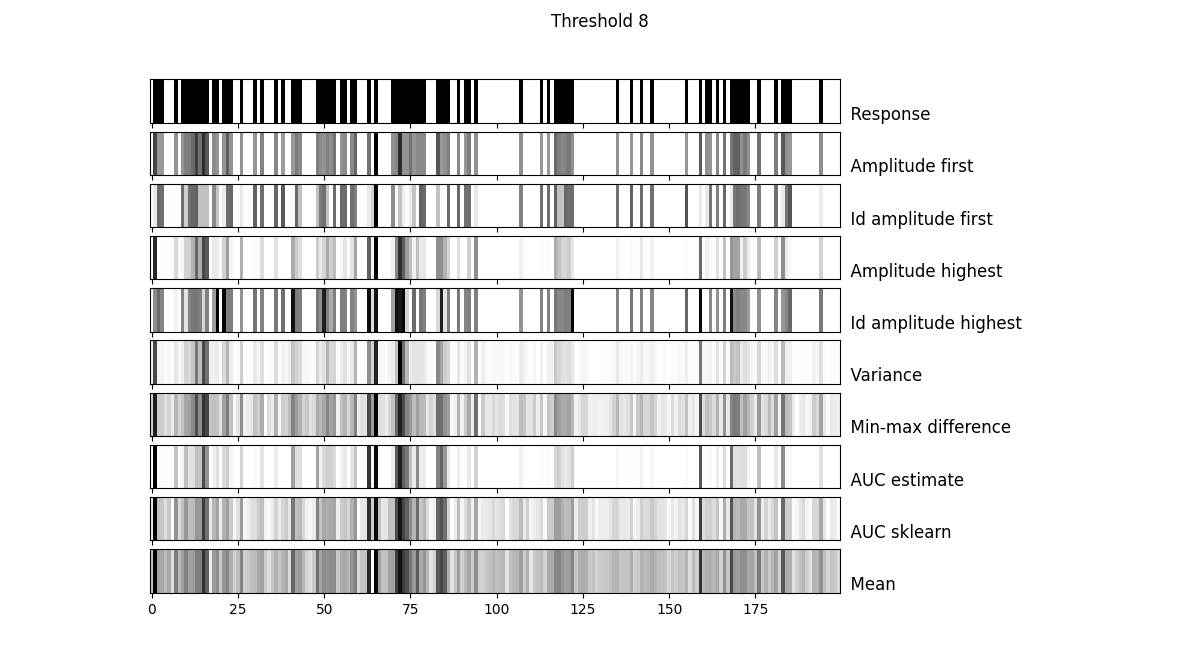

In [14]:
thr = list(responses.keys())[2]

fig, axs = prepare_barcode(10,200,title=f"Threshold {thr}")

plot_one_barcode(axs[0],responses[thr]['01-response'],title=f"Response")
plot_one_barcode(axs[1],responses[thr]['amp_first'],title=f"Amplitude first")
plot_one_barcode(axs[2],responses[thr]['amp_first_id'],title=f"Id amplitude first")
plot_one_barcode(axs[3],responses[thr]['amp_highest'],title=f"Amplitude highest")
plot_one_barcode(axs[4],responses[thr]['amp_highest_id'],title=f"Id amplitude highest")
plot_one_barcode(axs[5],responses[thr]['variance'],title=f"Variance")
plot_one_barcode(axs[6],responses[thr]['diff'],title=f"Min-max difference ")
plot_one_barcode(axs[7],responses[thr]['AUC_estimate'],title=f"AUC estimate")
plot_one_barcode(axs[8],responses[thr]['AUC_sklearn'],title=f"AUC sklearn")
plot_one_barcode(axs[9],responses[thr]['mean'],title=f"Mean")

z obrázků výše je vidět, že mezi těmi věcmi jsou korelace navzájem (místy asi fakt silné) - ty věci jsou "skoro stejné", je jedno, kterou z nich použiji, když tam korelace s ED nebo něčím jiným není, tak tam prostě není

In [15]:
stim_locatin = data_pytepfit['stim_location']

### Load structural (and functional) connectivity data

In [16]:
SC_W, SC_L, FC = data.load_pytepfit_sc()

SC_L = np.where(SC_W == 0,np.nan,SC_L)

/tmp/ipykernel_24979/3017092137.py:4: RuntimeWarning: divide by zero encountered in log
  axs[0].matshow(np.log(SC_W))


Text(0.5, 1.0, 'Structural connectivity - lengths (log)')

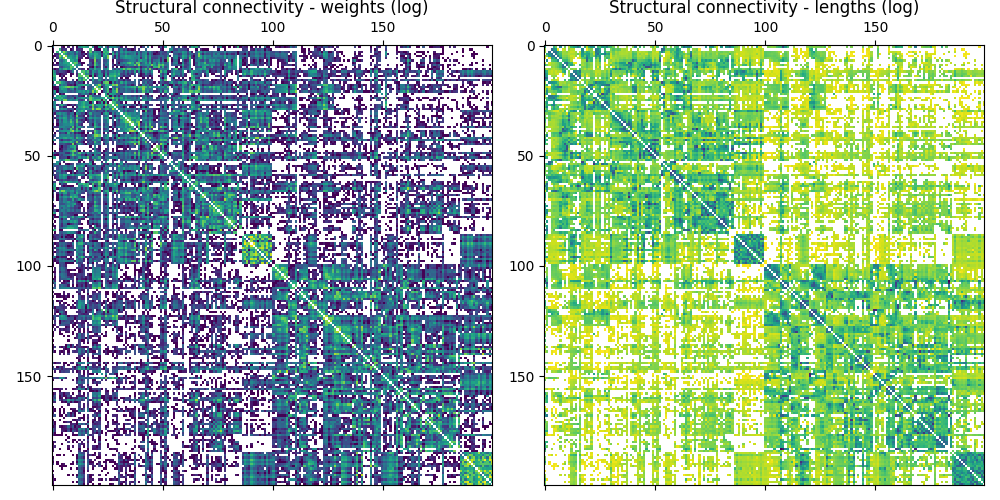

In [17]:
plt.rcParams['figure.figsize'] = [10, 5]

fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].matshow(np.log(SC_W))
axs[0].set_title("Structural connectivity - weights (log)")
axs[1].matshow(np.log(SC_L))
axs[1].set_title("Structural connectivity - lengths (log)")

Text(0.5, 1.0, 'ROI distances')

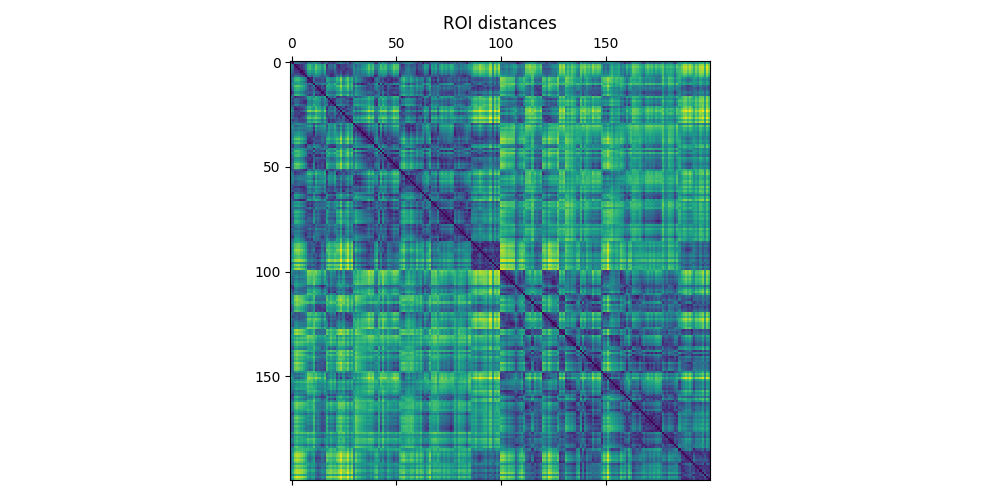

In [18]:
ED = data.schaefer_roi_distances(200)

fig, axs = plt.subplots(1, 1, tight_layout=True)
axs.matshow(ED)
axs.set_title("ROI distances")

In [19]:
from nilearn import plotting

df = pd.read_csv('../data/external/pytepfit/ROI_MAPPING.csv')
centroids = np.stack(df.geom_mne.apply(lambda x: np.fromstring(x[1:-1], dtype=float, sep=' ')).to_numpy(),axis=0)

In [20]:
dist_to_stim = np.zeros(ED.shape)
dist_to_stim[:,:] = np.nan
dist_to_stim[stim_locatin] = SC_L[stim_locatin] # + 1 # +1 tam je, aby se odlišila 0 a nan; pro SC_L ukáže, v čem by mohl být problém

view = plotting.view_connectome(dist_to_stim,centroids,linewidth=4.0,edge_cmap='jet',symmetric_cmap=False,node_color='gray',edge_threshold=1)
plt.rcParams['figure.figsize'] = [15, 15]
view.resize(1200,800)
view # proč k některým vrcholům nevedou čáry? - viz výše, zmatení 0 a nan, vyřeší +1

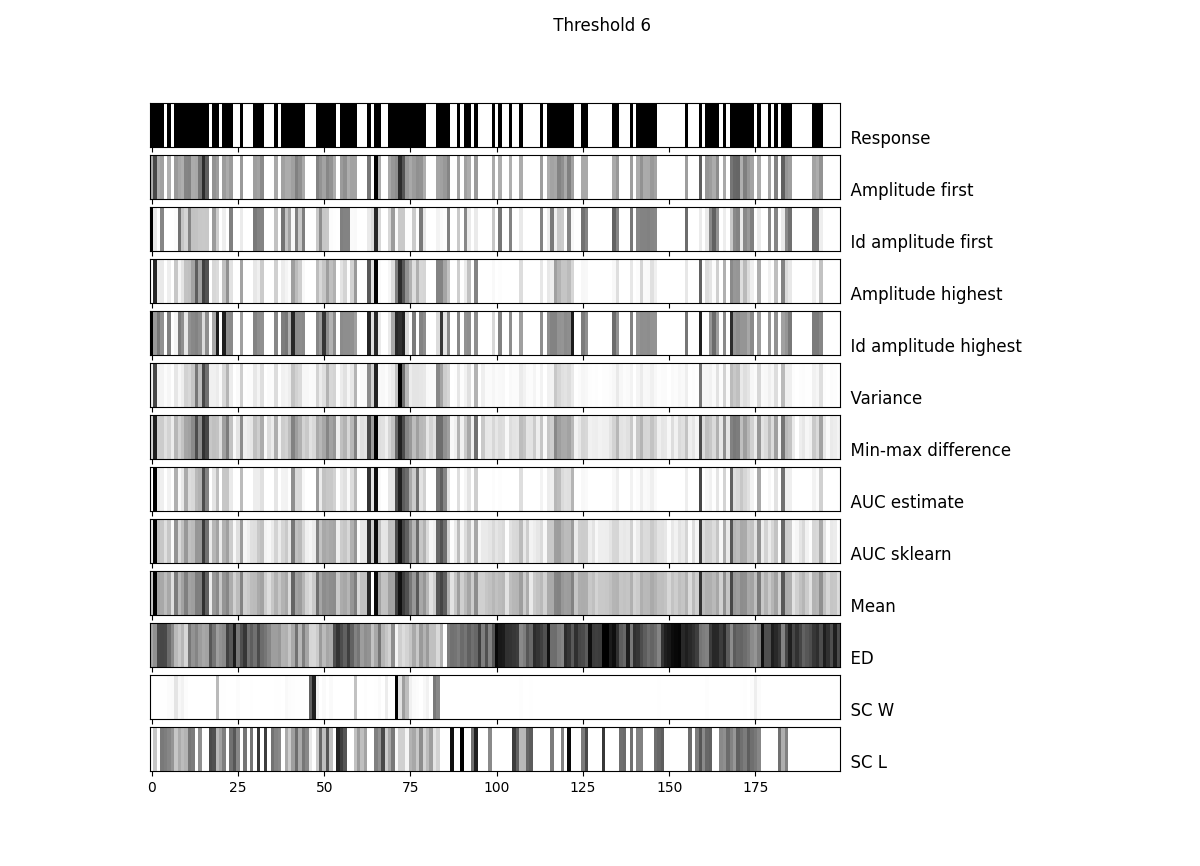

In [21]:
thr = list(responses.keys())[1]

fig, axs = prepare_barcode(13,200, title = f" Threshold {thr}")

plot_one_barcode(axs[0],responses[thr]['01-response'],title=f"Response")
plot_one_barcode(axs[1],responses[thr]['amp_first'],title=f"Amplitude first")
plot_one_barcode(axs[2],responses[thr]['amp_first_id'],title=f"Id amplitude first")
plot_one_barcode(axs[3],responses[thr]['amp_highest'],title=f"Amplitude highest")
plot_one_barcode(axs[4],responses[thr]['amp_highest_id'],title=f"Id amplitude highest")
plot_one_barcode(axs[5],responses[thr]['variance'],title=f"Variance")
plot_one_barcode(axs[6],responses[thr]['diff'],title=f"Min-max difference ")
plot_one_barcode(axs[7],responses[thr]['AUC_estimate'],title=f"AUC estimate")
plot_one_barcode(axs[8],responses[thr]['AUC_sklearn'],title=f"AUC sklearn")
plot_one_barcode(axs[9],responses[thr]['mean'],title=f"Mean")
plot_one_barcode(axs[10],ED[stim_locatin],title=f"ED")
plot_one_barcode(axs[11],SC_W[stim_locatin],title=f"SC W")
plot_one_barcode(axs[12],SC_L[stim_locatin],title=f"SC L")

## Correlations

In [25]:
PLOT=False

In [37]:
print(spearmanr(SC_W.flatten(),ED.flatten(),nan_policy='omit'))
print(spearmanr(SC_L.flatten(),ED.flatten(),nan_policy='omit'))
print(spearmanr(SC_W.flatten(),SC_L.flatten(),nan_policy='omit'))

SignificanceResult(statistic=-0.41824980229638786, pvalue=0.0)
SignificanceResult(statistic=0.7157168916070056, pvalue=0.0)
SignificanceResult(statistic=-0.5897822038378862, pvalue=0.0)


In [27]:
# shortcut for correlation of X with response probability and amplitude 
def coor_with_response(X):
    s = pd.Series(X[stim_locatin])
    # for b in below_threshold:
    #     s[b] = None

    for threshold in thr_range:
        print(f"------------- THRESHOLD {threshold} -------------")
        response_df = responses[threshold]

        stat = pd.DataFrame(index=response_df.keys())
        
        stat['r'] = response_df.corrwith(s,method=lambda x,y: spearmanr(x,y,nan_policy='omit')[0])
        stat['p'] = response_df.corrwith(s,method=lambda x,y: spearmanr(x,y,nan_policy='omit')[1])
        stat['sigf'] = np.where(stat['p']<0.05,'*','-')

        stat['n_val'] = response_df.count(axis=0)
        print(stat)


# p-val https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance

In [28]:
coor_with_response(ED)

------------- THRESHOLD 4 -------------
                       r             p sigf  n_val
01-response    -0.183295  9.377153e-03    *    200
amp_highest    -0.404824  1.205113e-07    *    159
amp_first      -0.299418  1.260423e-04    *    159
amp_first_id    0.171251  3.090276e-02    *    159
amp_highest_id  0.101973  2.008914e-01    -    159
variance       -0.456601  1.079250e-11    *    200
variance_ot    -0.445751  4.907061e-09    *    157
diff           -0.452069  1.821200e-11    *    200
diff_ot        -0.427722  2.305399e-08    *    157
AUC_estimate   -0.472967  3.068139e-10    *    159
AUC_sklearn    -0.425969  3.205480e-10    *    200
mean           -0.380146  2.820528e-08    *    200
------------- THRESHOLD 6 -------------
                       r             p sigf  n_val
01-response    -0.312821  6.484785e-06    *    200
amp_highest    -0.388208  2.150245e-05    *    113
amp_first      -0.229032  1.468307e-02    *    113
amp_first_id    0.340016  2.290249e-04    *    113
am

In [29]:
coor_with_response(SC_W) 

------------- THRESHOLD 4 -------------
                       r         p sigf  n_val
01-response     0.098635  0.164662    -    200
amp_highest     0.166728  0.035685    *    159
amp_first       0.168358  0.033894    *    159
amp_first_id   -0.147988  0.062659    -    159
amp_highest_id -0.106433  0.181787    -    159
variance        0.183371  0.009348    *    200
variance_ot     0.157833  0.048356    *    157
diff            0.188696  0.007452    *    200
diff_ot         0.165937  0.037803    *    157
AUC_estimate    0.249401  0.001523    *    159
AUC_sklearn     0.240828  0.000592    *    200
mean            0.233323  0.000884    *    200
------------- THRESHOLD 6 -------------
                       r         p sigf  n_val
01-response     0.141558  0.045558    *    200
amp_highest     0.170669  0.070707    -    113
amp_first       0.122465  0.196284    -    113
amp_first_id   -0.236454  0.011687    *    113
amp_highest_id -0.110425  0.244283    -    113
variance        0.183371  0

In [30]:
coor_with_response(SC_L) 

------------- THRESHOLD 4 -------------
                       r         p sigf  n_val
01-response    -0.182940  0.052446    -    200
amp_highest    -0.244640  0.018760    *    159
amp_first      -0.251561  0.015566    *    159
amp_first_id    0.172462  0.100192    -    159
amp_highest_id  0.144287  0.169994    -    159
variance       -0.308820  0.000875    *    200
variance_ot    -0.276238  0.008037    *    157
diff           -0.311007  0.000800    *    200
diff_ot        -0.266651  0.010620    *    157
AUC_estimate   -0.355810  0.000500    *    159
AUC_sklearn    -0.307747  0.000914    *    200
mean           -0.296078  0.001452    *    200
------------- THRESHOLD 6 -------------


                       r         p sigf  n_val
01-response    -0.184721  0.050152    -    200
amp_highest    -0.265327  0.027569    *    113
amp_first       0.065400  0.593410    -    113
amp_first_id    0.541027  0.000002    *    113
amp_highest_id  0.064369  0.599257    -    113
variance       -0.308820  0.000875    *    200
variance_ot    -0.284728  0.017729    *    112
diff           -0.311007  0.000800    *    200
diff_ot        -0.270150  0.024771    *    112
AUC_estimate   -0.446949  0.000118    *    113
AUC_sklearn    -0.307747  0.000914    *    200
mean           -0.296078  0.001452    *    200
------------- THRESHOLD 8 -------------
                       r         p sigf  n_val
01-response    -0.186178  0.048337    *    200
amp_highest    -0.318543  0.017778    *     87
amp_first      -0.122944  0.371198    -     87
amp_first_id    0.417645  0.001511    *     87
amp_highest_id  0.055309  0.688371    -     87
variance       -0.308820  0.000875    *    200
variance_ot    -0.28

In [31]:
# shortest path efficiency
shorest_paths,_ = metrics.distance_wei_floyd(SC_L)
shorest_path_eff = np.divide(1,shorest_paths)

coor_with_response(shorest_path_eff)

------------- THRESHOLD 4 -------------
                       r             p sigf  n_val
01-response     0.177604  1.186998e-02    *    200
amp_highest     0.400287  1.714892e-07    *    159
amp_first       0.289139  2.186712e-04    *    159
amp_first_id   -0.242459  2.075267e-03    *    159
amp_highest_id -0.126931  1.108543e-01    -    159
variance        0.463800  4.625960e-12    *    200
variance_ot     0.446790  4.476101e-09    *    157
diff            0.457183  1.008542e-11    *    200
diff_ot         0.428256  2.205086e-08    *    157
AUC_estimate    0.477251  2.013318e-10    *    159
AUC_sklearn     0.429423  2.223629e-10    *    200
mean            0.386105  1.636281e-08    *    200
------------- THRESHOLD 6 -------------
                       r             p sigf  n_val
01-response     0.317183  4.733942e-06    *    200
amp_highest     0.381429  3.069041e-05    *    113
amp_first       0.137817  1.454810e-01    -    113
amp_first_id   -0.475375  1.034347e-07    *    113
am

/tmp/ipykernel_24979/427274674.py:3: RuntimeWarning: divide by zero encountered in divide
  shorest_path_eff = np.divide(1,shorest_paths)


                       r             p sigf  n_val
01-response     0.384245  1.941697e-08    *    200
amp_highest     0.256629  4.406903e-02    *     62
amp_first       0.082874  5.219310e-01    -     62
amp_first_id   -0.437032  3.829665e-04    *     62
amp_highest_id -0.051907  6.886650e-01    -     62
variance        0.463800  4.625960e-12    *    200
variance_ot     0.240966  5.920626e-02    -     62
diff            0.457183  1.008542e-11    *    200
diff_ot         0.203898  1.119315e-01    -     62
AUC_estimate    0.440608  3.384053e-04    *     62
AUC_sklearn     0.429423  2.223629e-10    *    200
mean            0.386105  1.636281e-08    *    200
------------- THRESHOLD 12 -------------
                       r             p sigf  n_val
01-response     0.347361  4.668949e-07    *    200
amp_highest     0.328810  2.249687e-02    *     48
amp_first       0.172058  2.422516e-01    -     48
amp_first_id   -0.603620  5.581213e-06    *     48
amp_highest_id -0.093501  5.273170e-01   

In [38]:
com = metrics.communicability_wei(SC_W)
coor_with_response(com)

------------- THRESHOLD 4 -------------
                       r         p sigf  n_val
01-response     0.125745  0.076028    -    200
amp_highest     0.193354  0.014608    *    159
amp_first       0.182237  0.021501    *    159
amp_first_id   -0.148347  0.062019    -    159
amp_highest_id -0.144703  0.068785    -    159
variance        0.242381  0.000544    *    200
variance_ot     0.198541  0.012678    *    157
diff            0.243713  0.000506    *    200
diff_ot         0.196423  0.013680    *    157
AUC_estimate    0.272456  0.000512    *    159
AUC_sklearn     0.272392  0.000095    *    200
mean            0.252269  0.000314    *    200
------------- THRESHOLD 6 -------------
                       r         p sigf  n_val
01-response     0.181447  0.010131    *    200
amp_highest     0.165904  0.079059    -    113
amp_first       0.113855  0.229850    -    113
amp_first_id   -0.249790  0.007625    *    113
amp_highest_id -0.122644  0.195623    -    113
variance        0.242381  0

In [39]:
SI = metrics.search_information(SC_W,ED) # má tu být ED?

coor_with_response(SI)

/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:553: RuntimeWarning: divide by zero encountered in log2
  SI[i, j] = -np.log2(np.prod(pr_step_ff))
/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:554: RuntimeWarning: divide by zero encountered in log2
  SI[j, i] = -np.log2(np.prod(pr_step_bk))


------------- THRESHOLD 4 -------------
                       r         p sigf  n_val
01-response    -0.101806  0.152480    -    200
amp_highest    -0.175895  0.027058    *    159
amp_first      -0.177156  0.025962    *    159
amp_first_id    0.158056  0.047318    *    159
amp_highest_id  0.115883  0.147071    -    159
variance       -0.191389  0.006770    *    200
variance_ot    -0.166951  0.037243    *    157
diff           -0.196753  0.005347    *    200
diff_ot        -0.175123  0.028770    *    157
AUC_estimate   -0.261447  0.000906    *    159
AUC_sklearn    -0.250328  0.000362    *    200
mean           -0.242744  0.000551    *    200
------------- THRESHOLD 6 -------------
                       r         p sigf  n_val
01-response    -0.146836  0.038494    *    200
amp_highest    -0.182073  0.054688    -    113
amp_first      -0.126582  0.183536    -    113
amp_first_id    0.255495  0.006551    *    113
amp_highest_id  0.124849  0.189657    -    113
variance       -0.191389  0

In [40]:
# https://netneurolab.github.io/netneurotools/_modules/netneurotools/metrics.html#diffusion_efficiency
diffusion = metrics.diffusion_efficiency(SC_W)[1] # tahle funkce určitě má dostat SC, a ne délky L

coor_with_response(diffusion)

------------- THRESHOLD 4 -------------
                       r         p sigf  n_val
01-response    -0.285747  0.000041    *    200
amp_highest    -0.108204  0.174583    -    159
amp_first      -0.032864  0.680899    -    159
amp_first_id    0.087987  0.270088    -    159
amp_highest_id  0.067828  0.395599    -    159
variance       -0.334996  0.000001    *    200
variance_ot    -0.157918  0.048234    *    157
diff           -0.335297  0.000001    *    200
diff_ot        -0.162755  0.041688    *    157
AUC_estimate   -0.065002  0.415625    -    159
AUC_sklearn    -0.218021  0.001926    *    200
mean           -0.181733  0.010011    *    200
------------- THRESHOLD 6 -------------


/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:780: RuntimeWarning: divide by zero encountered in divide
  E_diff = np.divide(1, mfpt)


                       r         p sigf  n_val
01-response    -0.241464  0.000572    *    200
amp_highest    -0.017333  0.855411    -    113
amp_first      -0.011503  0.903754    -    113
amp_first_id    0.010921  0.908597    -    113
amp_highest_id  0.116879  0.217628    -    113
variance       -0.334996  0.000001    *    200
variance_ot    -0.061187  0.521604    -    112
diff           -0.335297  0.000001    *    200
diff_ot        -0.058684  0.538810    -    112
AUC_estimate   -0.022997  0.808953    -    113
AUC_sklearn    -0.218021  0.001926    *    200
mean           -0.181733  0.010011    *    200
------------- THRESHOLD 8 -------------
                       r         p sigf  n_val
01-response    -0.214114  0.002331    *    200
amp_highest     0.044817  0.680205    -     87
amp_first      -0.041773  0.700856    -     87
amp_first_id   -0.174262  0.106467    -     87
amp_highest_id  0.125493  0.246791    -     87
variance       -0.334996  0.000001    *    200
variance_ot     0.03

In [41]:
# tady té funkci možná dávám špatný vstup?
_,_,nav_paths,_,_ = metrics.navigation_wu(SC_L, SC_W)
nav_eff = np.divide(1,nav_paths)

coor_with_response(nav_eff)

/tmp/ipykernel_24979/3727610595.py:3: RuntimeWarning: divide by zero encountered in divide
  nav_eff = np.divide(1,nav_paths)


------------- THRESHOLD 4 -------------
                       r         p sigf  n_val
01-response     0.045251  0.524604    -    200
amp_highest     0.180710  0.022638    *    159
amp_first       0.218281  0.005708    *    159
amp_first_id   -0.087708  0.271615    -    159
amp_highest_id -0.008771  0.912628    -    159
variance        0.128035  0.070796    -    200
variance_ot     0.150151  0.060516    -    157
diff            0.143296  0.042943    *    200
diff_ot         0.170264  0.033011    *    157
AUC_estimate    0.216068  0.006230    *    159
AUC_sklearn     0.185037  0.008713    *    200
mean            0.191344  0.006644    *    200
------------- THRESHOLD 6 -------------
                       r         p sigf  n_val
01-response     0.105991  0.135240    -    200
amp_highest     0.173578  0.065969    -    113
amp_first       0.098002  0.301753    -    113
amp_first_id   -0.184081  0.050966    -    113
amp_highest_id -0.021415  0.821872    -    113
variance        0.128035  0

/tmp/ipykernel_24979/1143585558.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(n_rows, 1, figsize=(n_cols * pixel_per_bar / dpi, n_rows/1.5), dpi=dpi, sharex=True)


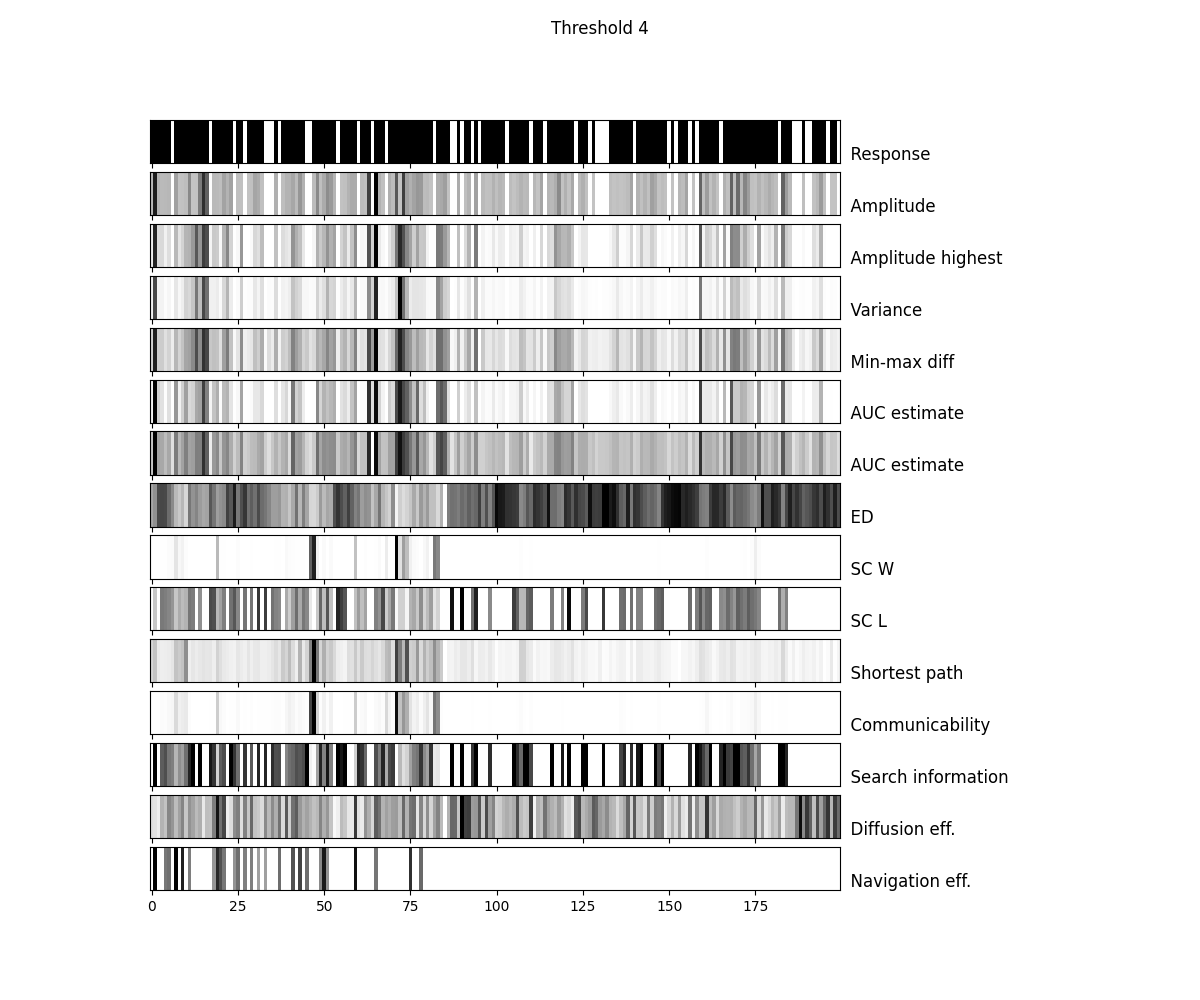

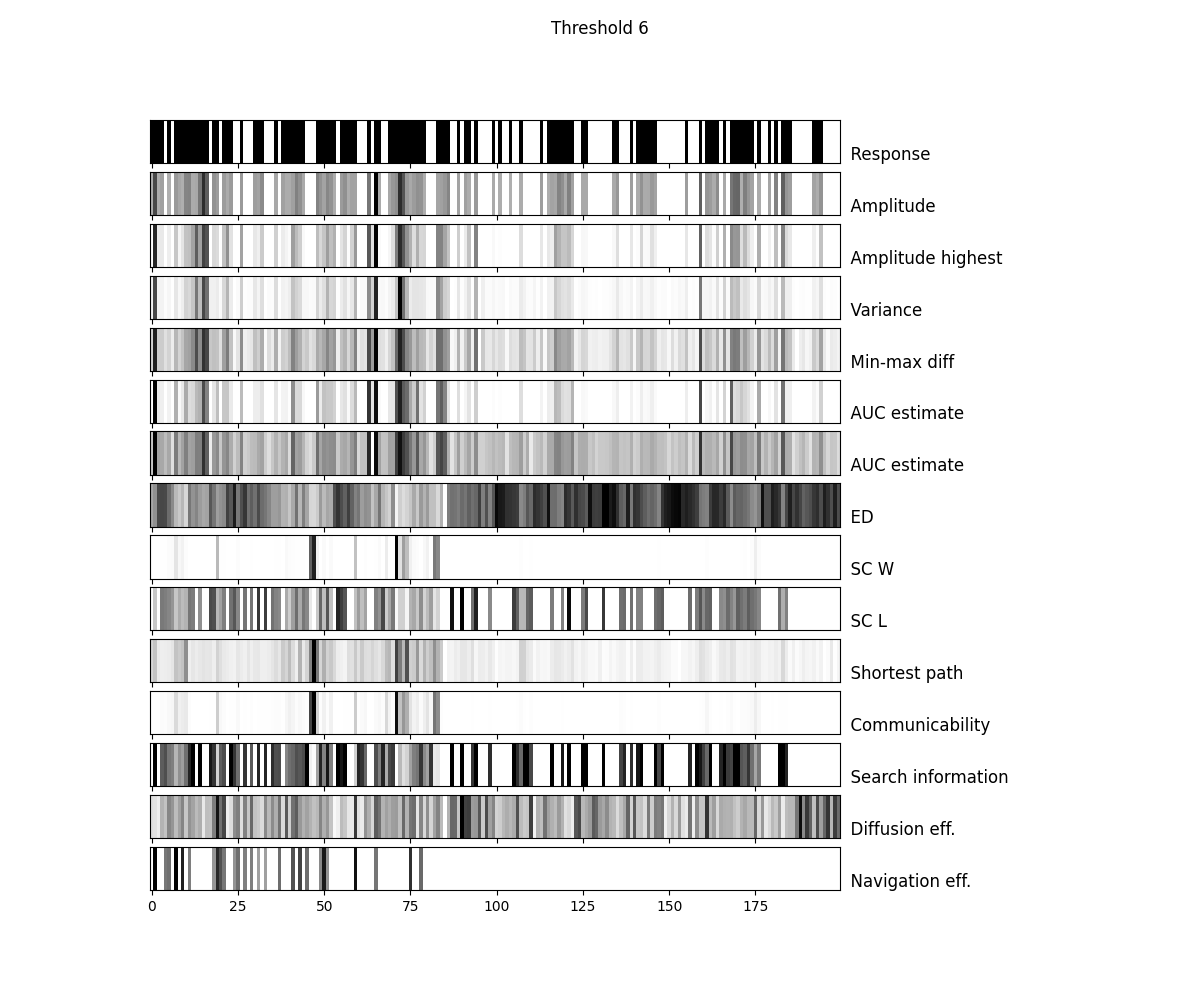

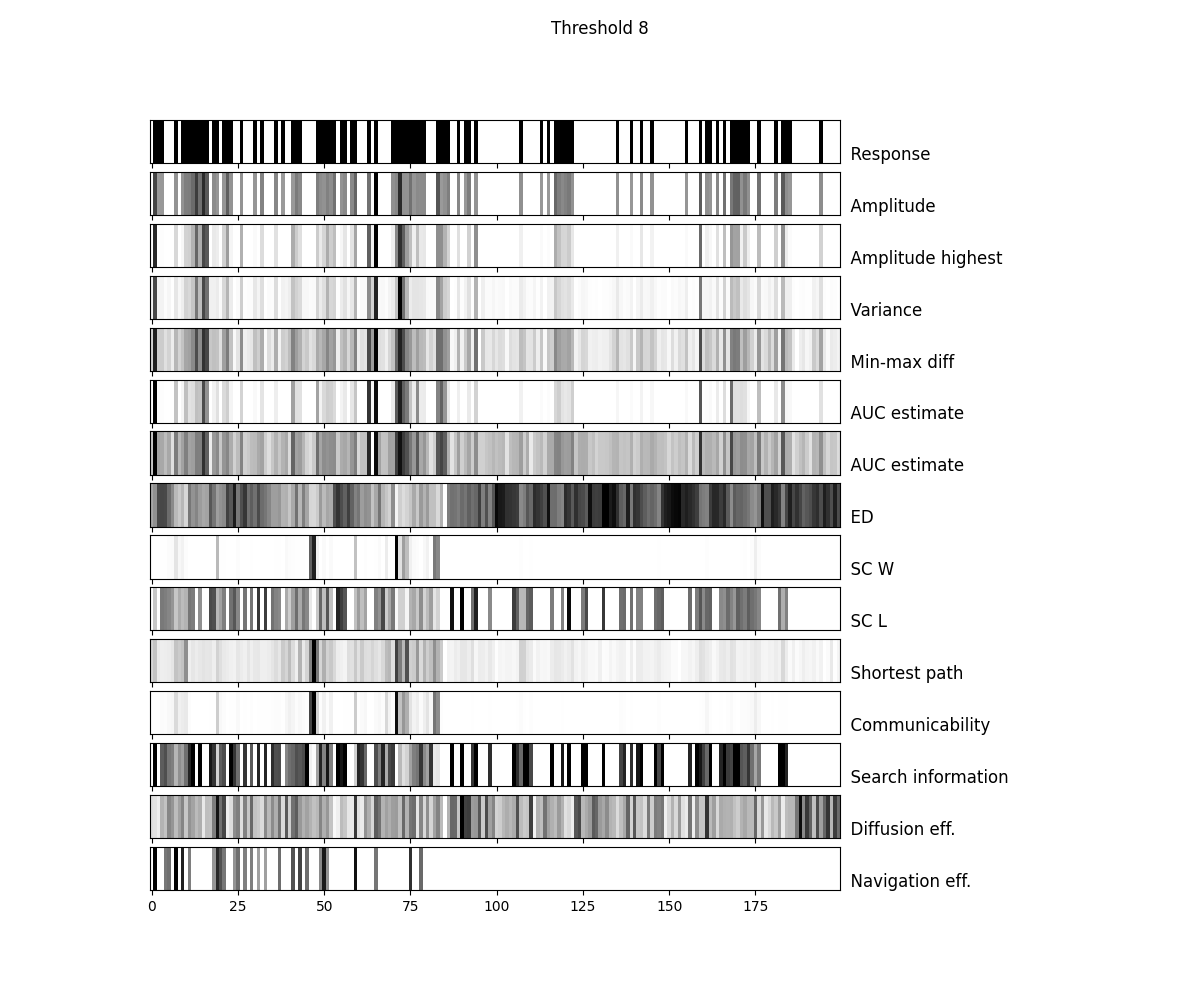

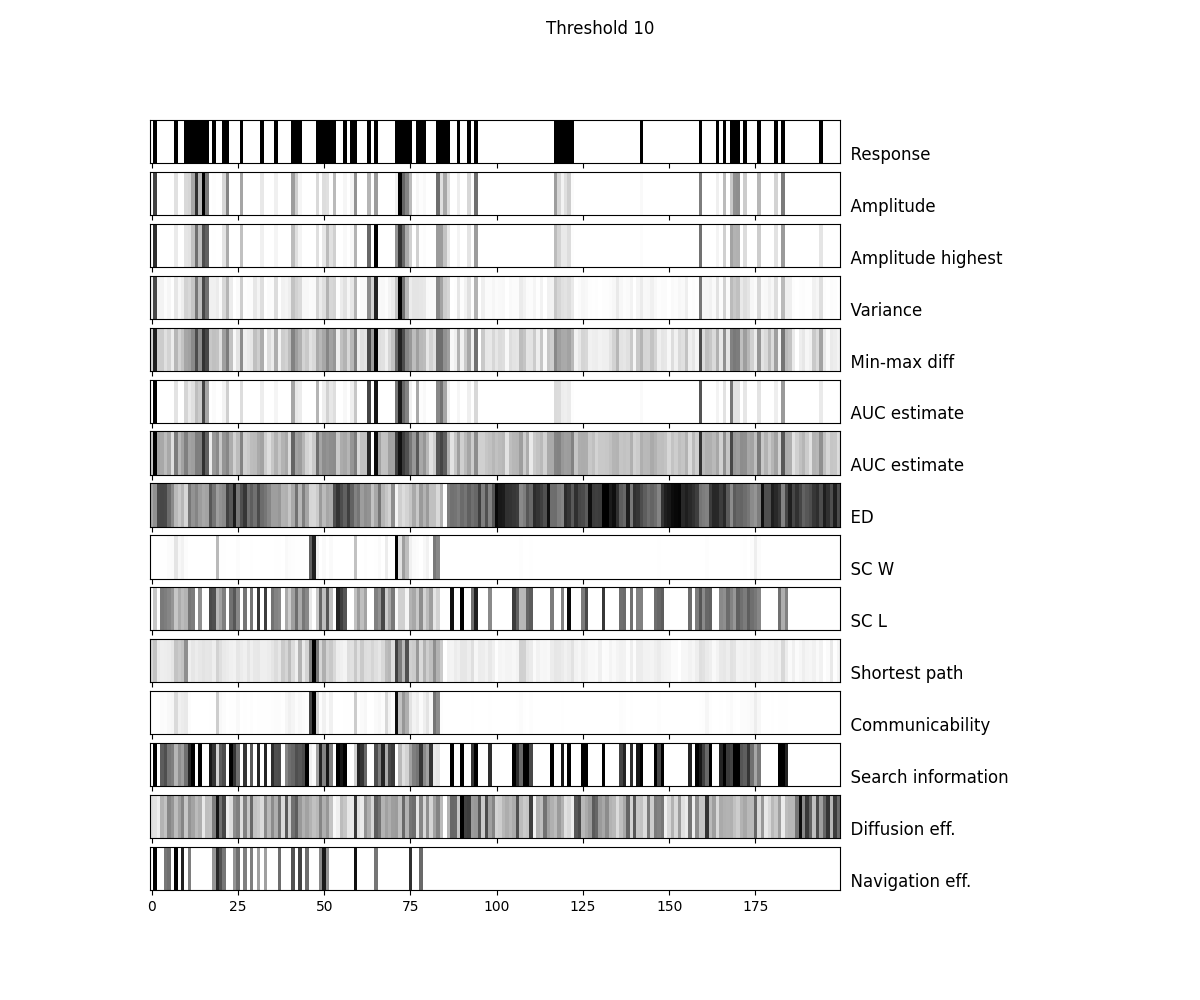

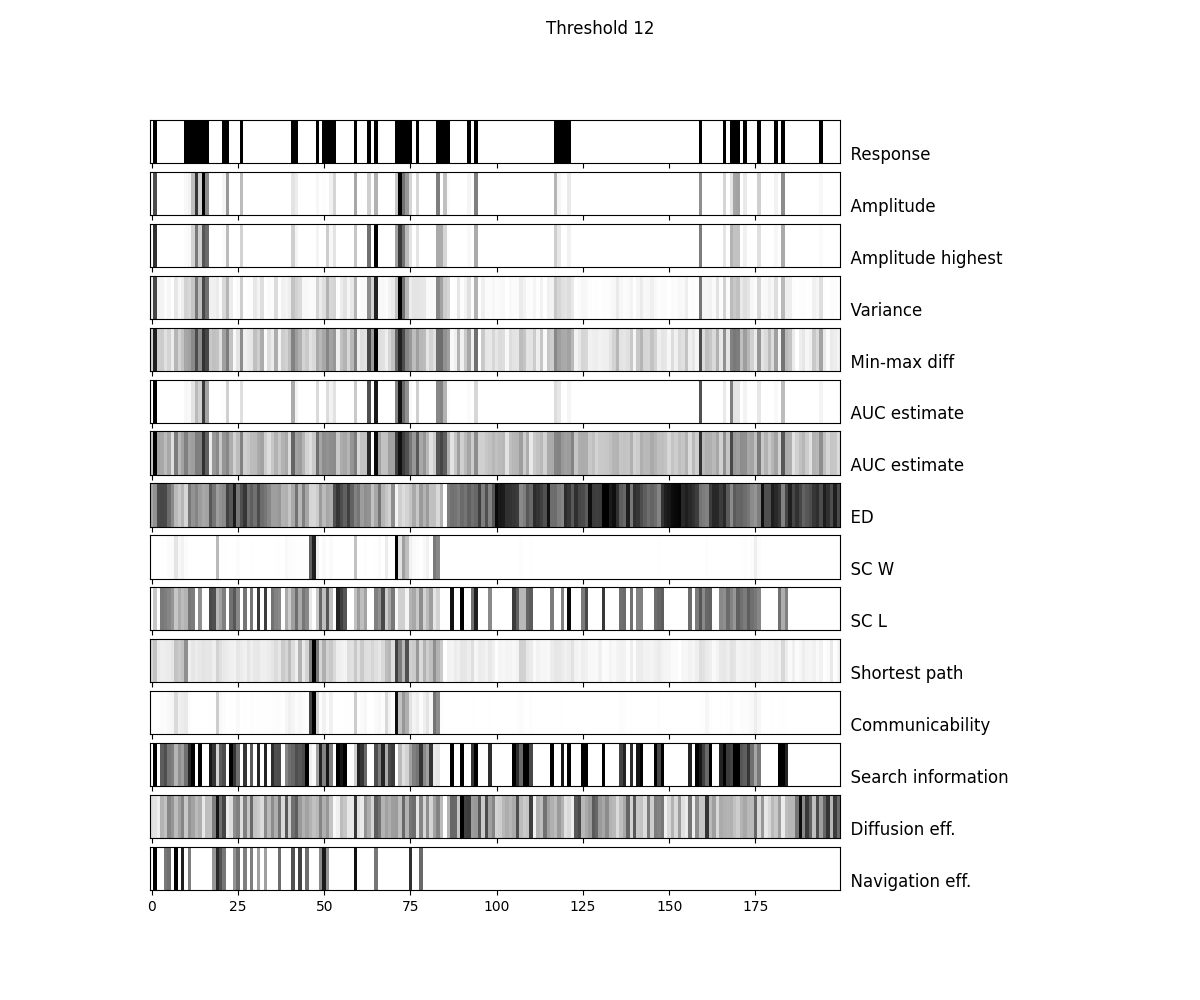

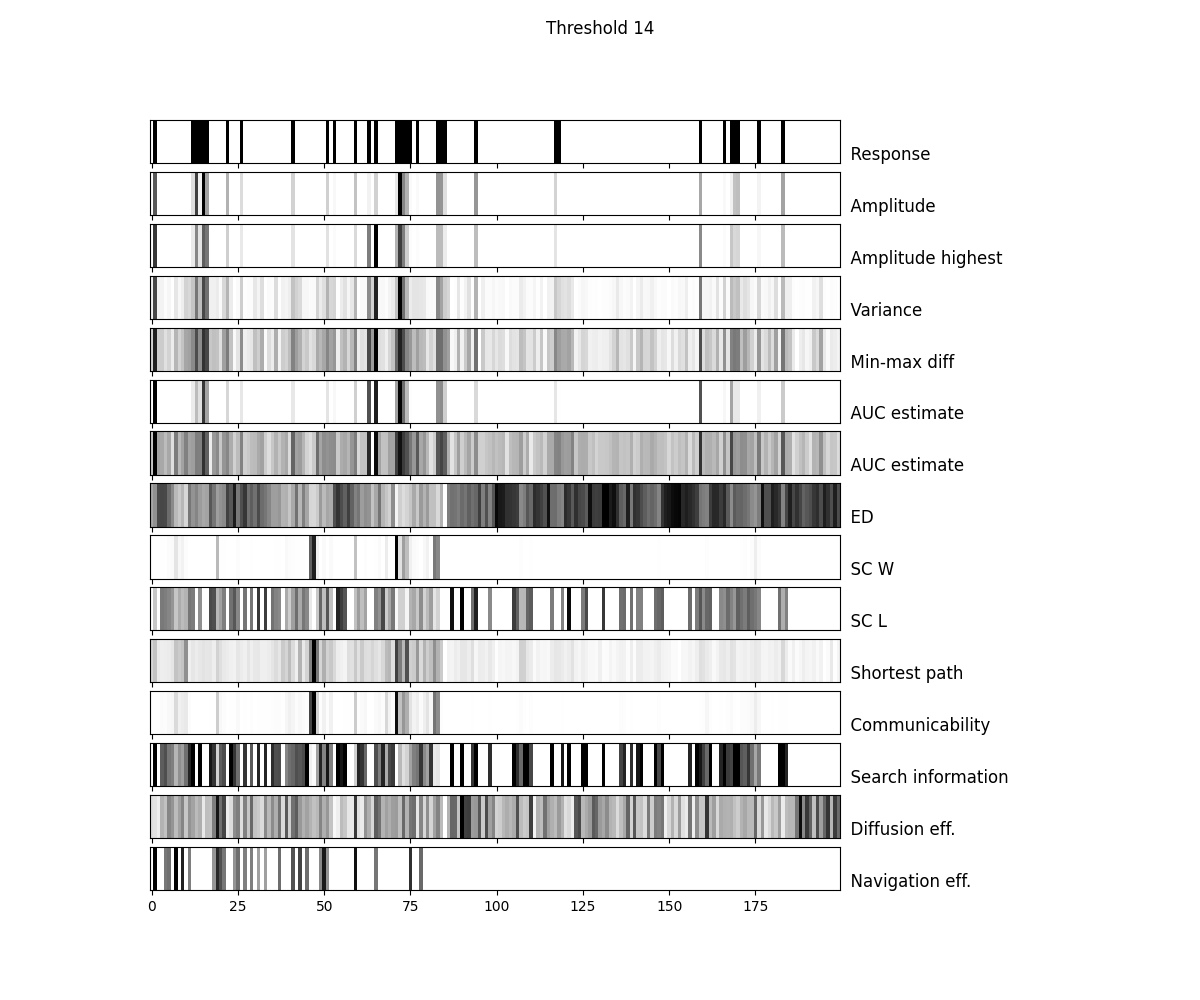

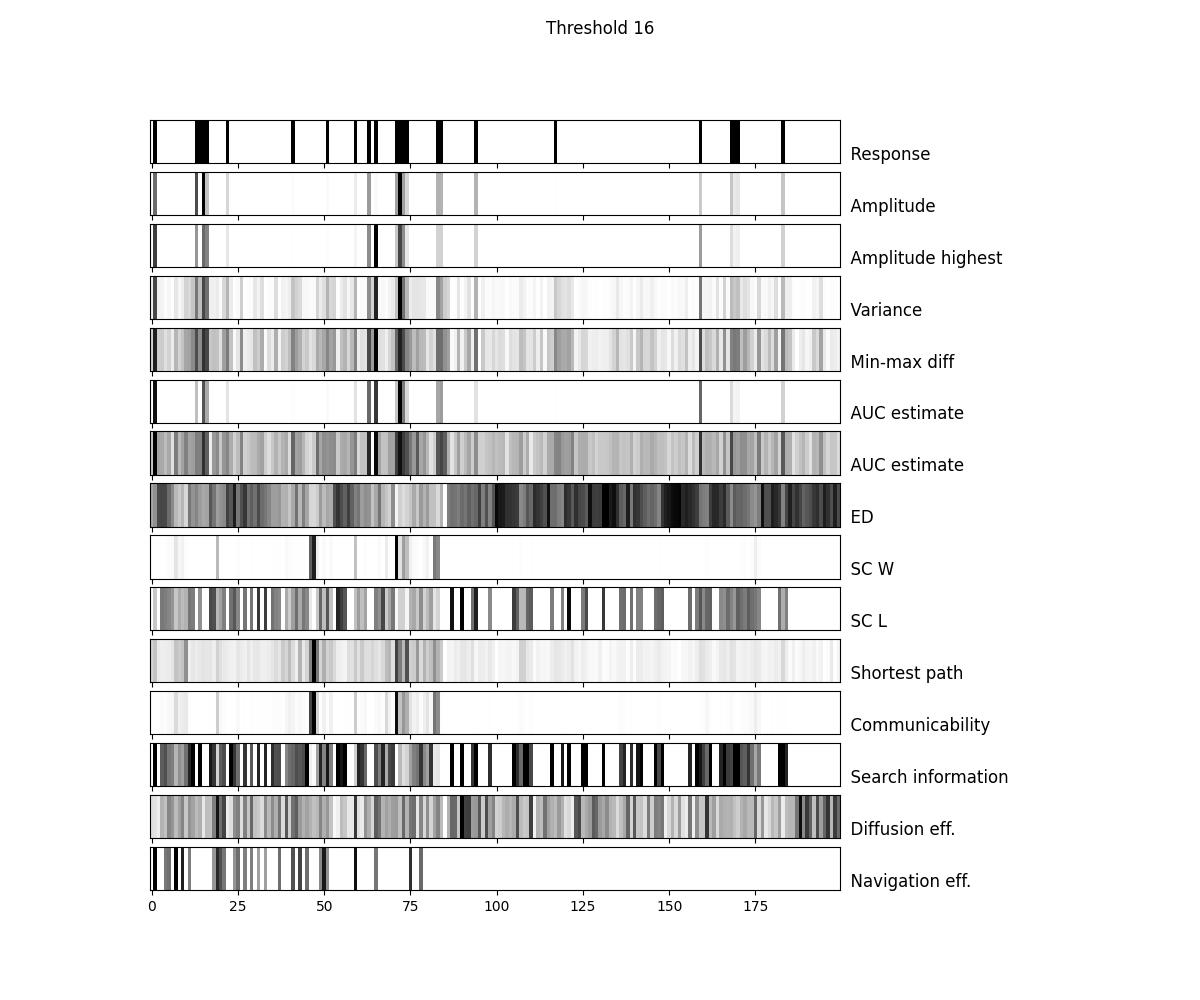

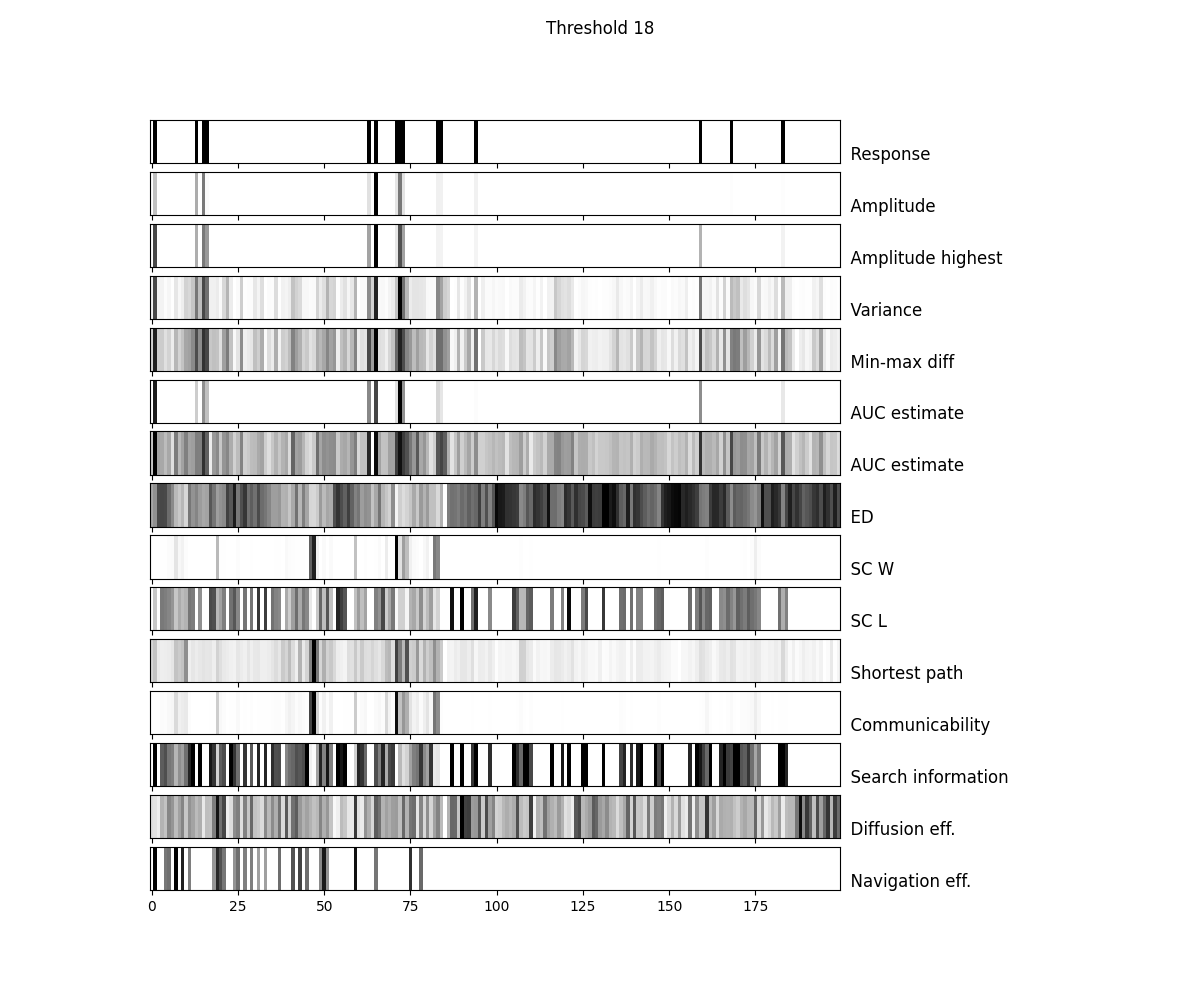

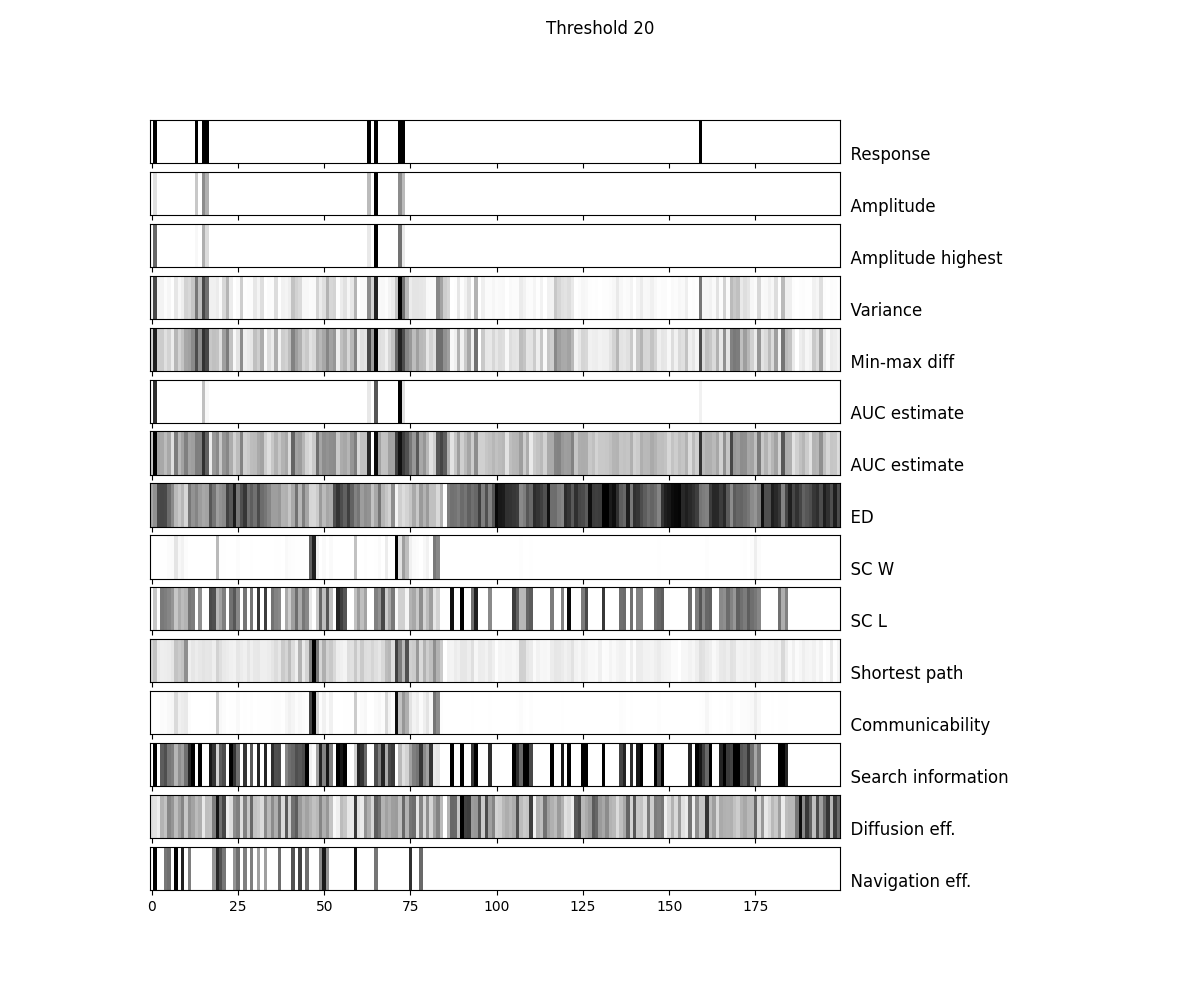

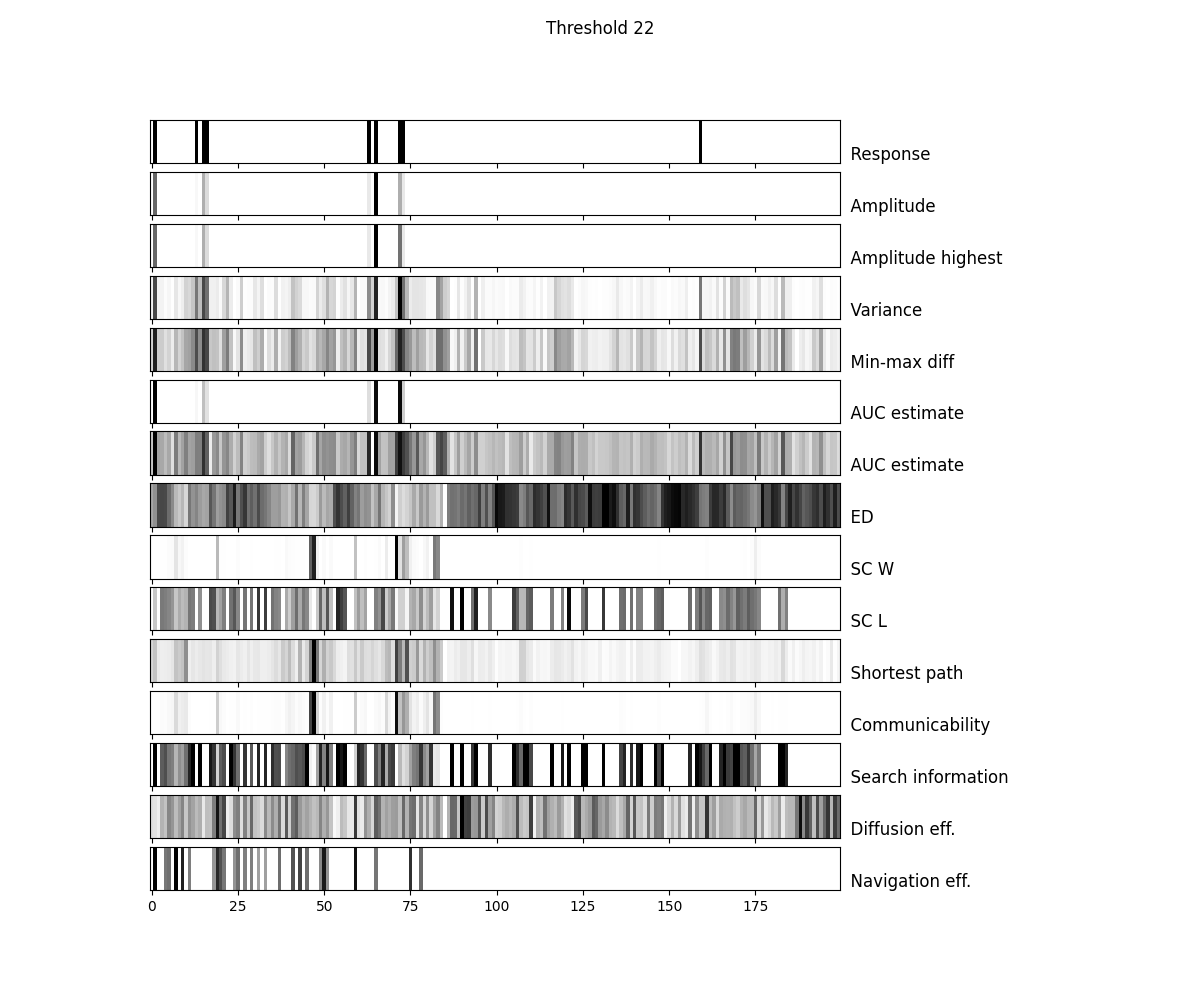

In [42]:
for thr in list(responses.keys()):
    fig, axs = prepare_barcode(15,200, title=f"Threshold {thr}")

    plot_one_barcode(axs[0],responses[thr]['01-response'],title=f"Response")
    plot_one_barcode(axs[1],responses[thr]['amp_first'],title=f"Amplitude")
    plot_one_barcode(axs[2],responses[thr]['amp_highest'],title=f"Amplitude highest")
    plot_one_barcode(axs[3],responses[thr]['variance'],title=f"Variance")
    plot_one_barcode(axs[4],responses[thr]['diff'],title=f"Min-max diff")
    plot_one_barcode(axs[5],responses[thr]['AUC_estimate'],title=f"AUC estimate")
    plot_one_barcode(axs[6],responses[thr]['mean'],title=f"AUC estimate")
    plot_one_barcode(axs[7],ED[stim_locatin],title=f"ED")
    plot_one_barcode(axs[8],SC_W[stim_locatin],title=f"SC W")
    plot_one_barcode(axs[9],SC_L[stim_locatin],title=f"SC L")
    plot_one_barcode(axs[10],shorest_path_eff[stim_locatin],title=f"Shortest path")
    plot_one_barcode(axs[11],com[stim_locatin],title=f"Communicability")
    plot_one_barcode(axs[12],SI[stim_locatin],title=f"Search information")
    plot_one_barcode(axs[13],diffusion[stim_locatin],title=f"Diffusion eff.")
    plot_one_barcode(axs[14],nav_eff[stim_locatin],title=f"Navigation eff.")